In [1]:
from importlib import reload
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
from scipy.interpolate import RegularGridInterpolator
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

import plotting   
import importlib
importlib.reload(plotting)

<module 'plotting' from '/home/orincon/Review-Seismic-Waves/main/03_finite_difference_helmholtz2D/../../utils/plotting.py'>

In [ ]:
 

# ==========================================================
# 2D Problem:
#     ∇²f = -(5π)² sin(5πx) sin(5πy)
#     f = 0 on the boundaries
# Analytical solution: f(x,y) = sin(5πx) sin(5πy)
# ==========================================================

def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# General parameters
N_values = list(range(10, 51, 5))  # total points per axis (including boundaries)
relative_errors = []
times = []
results = {}
n_runs = 1

# ==========================================================
# Compute numerical solutions, errors, and timings
# ==========================================================
for N in N_values:
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    h = x[1] - x[0]
    n = N * N

    # Apply Dirichlet BCs: zero at boundaries
    mask_inner = np.ones((N, N), dtype=bool)
    mask_inner[0, :] = mask_inner[-1, :] = False
    mask_inner[:, 0] = mask_inner[:, -1] = False
    inner_indices = np.argwhere(mask_inner)
    n_int = inner_indices.shape[0]

    run_times = []
    for _ in range(n_runs):
        start = time.time()

        # Build matrix for interior points only
        A = np.zeros((n_int, n_int))
        index_map = -np.ones((N, N), dtype=int)
        for k, (i, j) in enumerate(inner_indices):
            index_map[i, j] = k

        for k, (i, j) in enumerate(inner_indices):
            A[k, k] = -4
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if index_map[ni, nj] != -1:
                    A[k, index_map[ni, nj]] = 1

        A /= h**2
        b = rhs(X[mask_inner], Y[mask_inner])
        f_int = np.linalg.solve(A, b)
        run_times.append(time.time() - start)

    elapsed_mean = np.mean(run_times)

    # Reconstruct full field
    f_total = np.zeros_like(X)
    f_total[mask_inner] = f_int
    f_exact_total = f_exact(X, Y)

    rel_error = np.max(np.abs(f_total - f_exact_total)) / np.max(np.abs(f_exact_total))
    relative_errors.append(rel_error)
    times.append(elapsed_mean)
    results[N] = (X, Y, f_total)
 
# ==========================================================
# Compact Figure Layout with Aligned Mesh Row
# ==========================================================
fig = plt.figure(figsize=(7.5, 6.5))
outer_gs = GridSpec(
    4, 1,
    height_ratios=[0.9, 0.85, 0.5, 0.5],
    figure=fig,
    hspace=0.12  # overall space (moderate)
)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [10, 20, 30]
 

# === Row 0: Meshes (aligned with contours) ===
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_examples):
    ax = fig.add_subplot(gs_mesh[0, i])
    X, Y, _ = results[N]
    ax.scatter(X, Y, color='tab:gray', s=0.5)
    #ax.set_xlim(-0.02, 1.02)
    #ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Anotación lateral para mallas
 
fig.text(0.055, 0.77, r"Malla", fontsize=8, va="center", ha="left", rotation=90)

# === Row 1: 2D contours ===
gs_top = outer_gs[1].subgridspec(1, 3, wspace=0.35, hspace=0.00)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )
    border_mask = (X == 0) | (X == 1) | (Y == 0) | (Y == 1)
    #ax.scatter(X[border_mask], Y[border_mask], color="tab:gray", s=3, zorder=2)

    y_line = 0.40
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_line), color=color, lw=2, zorder=3)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Anotación lateral para contornos
fig.text(0.05, 0.52, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 2: 1D slices ===
gs_mid = outer_gs[2].subgridspec(1, 3, wspace=0.42, hspace=0.00)


for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F = results[N]
    idx_mid = np.argmin(np.abs(Y[0, :] - 0.40))
    ax.plot(X[:, idx_mid], F[:, idx_mid], '-', color=color, lw=1.2)
    ax.plot(X[:, idx_mid], np.zeros_like(X[:, idx_mid]), '.', color='tab:gray', markersize=3)
    #ax.set_ylim(-2.0, 2.0)
    ax.axis('off')

# Anotación lateral para cortes 1D
fig.text(0.05, 0.34, r"$\hat{f}(x,0.40)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 3: Error and time ===
 
gs_bottom = outer_gs[3].subgridspec(1, 2, wspace=0.30, hspace=0.0)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

ax_errN.plot(np.array(N_values)**2, relative_errors, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errN.plot(N_values[idx]**2, relative_errors[idx], '.', color=color, markersize=8)
ax_errN.set_xlabel('Número de puntos')
ax_errN.set_ylabel('Error relativo')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

ax_errT.plot(np.array(N_values)**2, times, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errT.plot(N_values[idx]**2, times[idx], '.', color=color, markersize=8)
ax_errT.set_xlabel('Número de puntos')
ax_errT.set_ylabel('Tiempo (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)

plt.savefig("figs/helmholtz2D_convergence.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/helmholtz2D_convergence.pdf", dpi=150, bbox_inches='tight')
plt.show() 


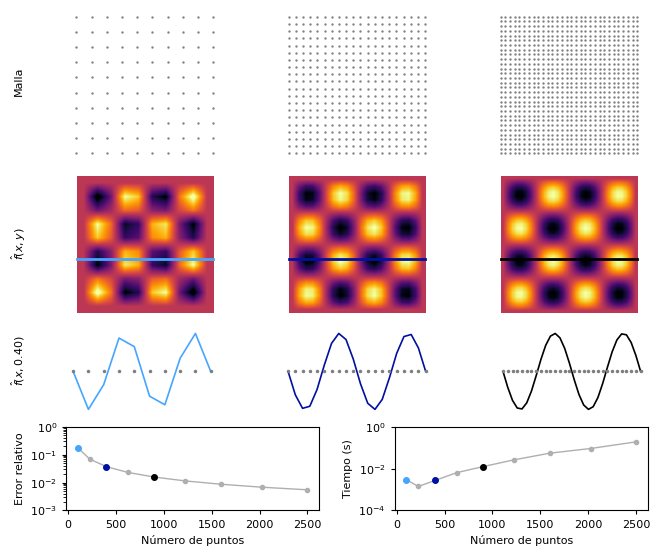

In [91]:
# ==========================================================
# Compact Figure Layout with Aligned Mesh Row
# ==========================================================
fig = plt.figure(figsize=(7.5, 6.5))
outer_gs = GridSpec(
    4, 1,
    height_ratios=[0.9, 0.85, 0.5, 0.5],
    figure=fig,
    hspace=0.12  # overall space (moderate)
)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [10, 20, 30]
 

# === Row 0: Meshes (aligned with contours) ===
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_examples):
    ax = fig.add_subplot(gs_mesh[0, i])
    X, Y, _ = results[N]
    ax.scatter(X, Y, color='tab:gray', s=0.5)
    #ax.set_xlim(-0.02, 1.02)
    #ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Anotación lateral para mallas
 
fig.text(0.055, 0.77, r"Malla", fontsize=8, va="center", ha="left", rotation=90)

# === Row 1: 2D contours ===
gs_top = outer_gs[1].subgridspec(1, 3, wspace=0.35, hspace=0.00)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )
    border_mask = (X == 0) | (X == 1) | (Y == 0) | (Y == 1)
    #ax.scatter(X[border_mask], Y[border_mask], color="tab:gray", s=3, zorder=2)

    y_line = 0.40
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_line), color=color, lw=2, zorder=3)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Anotación lateral para contornos
fig.text(0.05, 0.52, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 2: 1D slices ===
gs_mid = outer_gs[2].subgridspec(1, 3, wspace=0.42, hspace=0.00)


for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F = results[N]
    idx_mid = np.argmin(np.abs(Y[0, :] - 0.40))
    ax.plot(X[:, idx_mid], F[:, idx_mid], '-', color=color, lw=1.2)
    ax.plot(X[:, idx_mid], np.zeros_like(X[:, idx_mid]), '.', color='tab:gray', markersize=3)
    #ax.set_ylim(-2.0, 2.0)
    ax.axis('off')

# Anotación lateral para cortes 1D
fig.text(0.05, 0.34, r"$\hat{f}(x,0.40)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 3: Error and time ===
 
gs_bottom = outer_gs[3].subgridspec(1, 2, wspace=0.30, hspace=0.0)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

ax_errN.plot(np.array(N_values)**2, relative_errors, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errN.plot(N_values[idx]**2, relative_errors[idx], '.', color=color, markersize=8)
ax_errN.set_xlabel('Número de puntos')
ax_errN.set_ylabel('Error relativo')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

ax_errT.plot(np.array(N_values)**2, times, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errT.plot(N_values[idx]**2, times[idx], '.', color=color, markersize=8)
ax_errT.set_xlabel('Número de puntos')
ax_errT.set_ylabel('Tiempo (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)

plt.savefig("figs/helmholtz2D_convergence.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/helmholtz2D_convergence.pdf", dpi=150, bbox_inches='tight')
plt.show()


N= 10 | Error Relativo = 1.594e-01 | Tiempo = 0.001s
N= 15 | Error Relativo = 6.568e-02 | Tiempo = 0.002s
N= 20 | Error Relativo = 3.643e-02 | Tiempo = 0.004s
N= 25 | Error Relativo = 2.272e-02 | Tiempo = 0.010s
N= 30 | Error Relativo = 1.553e-02 | Tiempo = 0.013s
N= 35 | Error Relativo = 1.134e-02 | Tiempo = 0.025s
N= 40 | Error Relativo = 8.638e-03 | Tiempo = 0.043s
N= 45 | Error Relativo = 6.779e-03 | Tiempo = 0.088s
N= 50 | Error Relativo = 5.479e-03 | Tiempo = 0.196s


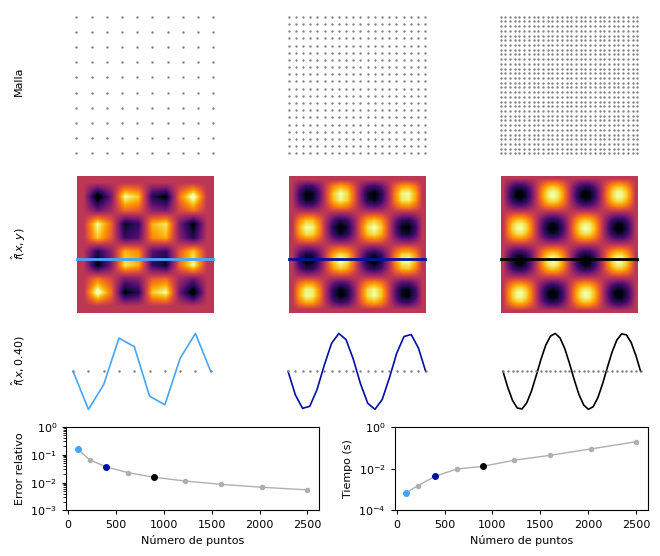

In [96]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata

# ==========================================================
# Problema 2D: Laplace/Poisson
# ==========================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# Parámetros generales
N_values = list(range(10, 51, 5))
relative_errors = []
times = []
results = {}
n_runs = 1

# Malla de referencia (100x100) para error relativo
Nx_ref, Ny_ref = 100, 100
x_ref = np.linspace(0, 1, Nx_ref)
y_ref = np.linspace(0, 1, Ny_ref)
X_ref, Y_ref = np.meshgrid(x_ref, y_ref, indexing="ij")
f_exact_ref = f_exact(X_ref, Y_ref)

# ==========================================================
# Solución numérica y errores
# ==========================================================
for N in N_values:
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    h = x[1] - x[0]

    # Máscara interior
    mask_inner = np.ones((N, N), dtype=bool)
    mask_inner[0, :] = mask_inner[-1, :] = False
    mask_inner[:, 0] = mask_inner[:, -1] = False
    inner_indices = np.argwhere(mask_inner)
    n_int = inner_indices.shape[0]

    run_times = []
    for _ in range(n_runs):
        start = time.time()

        # Construcción de la matriz A
        A = np.zeros((n_int, n_int))
        index_map = -np.ones((N, N), dtype=int)
        for k, (i, j) in enumerate(inner_indices):
            index_map[i, j] = k

        for k, (i, j) in enumerate(inner_indices):
            A[k, k] = -4
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if index_map[ni, nj] != -1:
                    A[k, index_map[ni, nj]] = 1

        A /= h**2
        b = rhs(X[mask_inner], Y[mask_inner])
        f_int = np.linalg.solve(A, b)
        run_times.append(time.time() - start)

    elapsed_mean = np.mean(run_times)

    # Reconstrucción de la solución completa
    f_total = np.zeros_like(X)
    f_total[mask_inner] = f_int

    # ===== Interpolación a malla de 100x100 =====
    points = np.column_stack((X.ravel(), Y.ravel()))
    values = f_total.ravel()
    f_interp = griddata(points, values, (X_ref, Y_ref), method='cubic', fill_value=0)

    # Error relativo interpolado
    rel_error = np.linalg.norm(f_interp - f_exact_ref) / np.linalg.norm(f_exact_ref)

    relative_errors.append(rel_error)
    times.append(elapsed_mean)
    results[N] = (X, Y, f_total)

    print(f"N={N:3d} | Error Relativo = {rel_error:.3e} | Tiempo = {elapsed_mean:.3f}s")

# ==========================================================
# Figura compacta
# ==========================================================
fig = plt.figure(figsize=(7.5, 6.5))
outer_gs = GridSpec(4, 1, height_ratios=[0.9, 0.85, 0.5, 0.5], figure=fig, hspace=0.12)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [10, 20, 30]

# === Row 0: Mallas ===
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_examples):
    ax = fig.add_subplot(gs_mesh[0, i])
    X, Y, _ = results[N]
    ax.scatter(X, Y, color='tab:gray', s=0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
fig.text(0.055, 0.77, r"Malla", fontsize=8, va="center", ha="left", rotation=90)

# === Row 1: 2D contours ===
gs_top = outer_gs[1].subgridspec(1, 3, wspace=0.35, hspace=0.00)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )
    border_mask = (X == 0) | (X == 1) | (Y == 0) | (Y == 1)
    #ax.scatter(X[border_mask], Y[border_mask], color="tab:gray", s=3, zorder=2)

    y_line = 0.40
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_line), color=color, lw=2, zorder=3)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Anotación lateral para contornos
fig.text(0.05, 0.52, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 2: 1D slices ===
gs_mid = outer_gs[2].subgridspec(1, 3, wspace=0.42, hspace=0.00)


for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F = results[N]
    idx_mid = np.argmin(np.abs(Y[0, :] - 0.40))
    ax.plot(X[:, idx_mid], F[:, idx_mid], '-', color=color, lw=1.2)
    ax.plot(X[:, idx_mid], np.zeros_like(X[:, idx_mid]), '.', color='tab:gray', markersize=1.5)
    #ax.set_ylim(-2.0, 2.0)
    ax.axis('off')

# Anotación lateral para cortes 1D
fig.text(0.05, 0.34, r"$\hat{f}(x,0.40)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 3: Error and time ===
 
gs_bottom = outer_gs[3].subgridspec(1, 2, wspace=0.30, hspace=0.0)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

ax_errN.plot(np.array(N_values)**2, relative_errors, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errN.plot(N_values[idx]**2, relative_errors[idx], '.', color=color, markersize=8)
ax_errN.set_xlabel('Número de puntos')
ax_errN.set_ylabel('Error relativo')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

ax_errT.plot(np.array(N_values)**2, times, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errT.plot(N_values[idx]**2, times[idx], '.', color=color, markersize=8)
ax_errT.set_xlabel('Número de puntos')
ax_errT.set_ylabel('Tiempo (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)

plt.savefig("figs/helmholtz2D_convergence.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/helmholtz2D_convergence.pdf", dpi=150, bbox_inches='tight')
plt.show()
